# Pandas 3 (Merging and Reshaping)

Sometimes, the way the data is stored in files or CSVs is not the way you need it for easy data processing. Often, one spends a lot of time "wrangling" the data into shape; the processing itself may even be easy in comparison.

A big plus point of Pandas is that it offers many tools to make the most common data wrangling operations relatively painless.

This lecture will look at some such problems:

* Merging multiple DataFrames, 
* Transforming data using ranks and quantiles, and
* Reshaping the data via pivot_table(), stack() and unstack()

## Merging DataFrames

Here's the setup: we have a bunch of DataFrames, each of which contains bits of the information we need. Ideally we want to combine them together into one DataFrame that we can easily work with. 

We will use a dataset of a Question-Answering service where users ask questions about Pandas, which are answered by other users (data [here](https://www.dropbox.com/s/zux0ed09j4fp5fy/tutorial_files.zip)).

In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
askers = pd.read_csv('Pandas_3_data/PandasUsers.csv')
questions = pd.read_csv('Pandas_3_data/PandasPosts.csv')
helpers = pd.read_csv('Pandas_3_data/PandasAnswerers.csv')
answers = pd.read_csv('Pandas_3_data/PandasAnswers.csv')

In [3]:
askers.columns.values

array(['Id', 'Reputation', 'CreationDate', 'DisplayName',
       'LastAccessDate', 'WebsiteUrl', 'Location', 'AboutMe', 'Views',
       'UpVotes', 'DownVotes', 'EmailHash', 'Age'], dtype=object)

In [4]:
questions.columns.values

array(['Id', 'PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'OwnerDisplayName',
       'LastEditorUserId', 'LastEditDate', 'LastActivityDate', 'Title',
       'Tags', 'AnswerCount', 'CommentCount', 'FavoriteCount',
       'ClosedDate'], dtype=object)

In [5]:
helpers.columns.values

array(['Id', 'Reputation', 'CreationDate', 'DisplayName',
       'LastAccessDate', 'WebsiteUrl', 'Location', 'AboutMe', 'Views',
       'UpVotes', 'DownVotes', 'EmailHash', 'Age'], dtype=object)

In [6]:
answers.columns.values

array(['Id', 'PostTypeId', 'ParentId', 'CreationDate', 'Score', 'Body',
       'OwnerUserId', 'OwnerDisplayName', 'LastEditorUserId',
       'LastEditorDisplayName', 'LastEditDate', 'LastActivityDate',
       'CommentCount'], dtype=object)

In [7]:
askers.iloc[0]

Id                                         1843099
Reputation                                     100
CreationDate                   2012-11-21 19:25:04
DisplayName                            user1843099
LastAccessDate                 2013-02-03 03:46:50
WebsiteUrl                                     NaN
Location                                       NaN
AboutMe                                        NaN
Views                                            0
UpVotes                                         16
DownVotes                                        0
EmailHash         17a9c54b937f8b505dcb3b0b5b34cbb6
Age                                            NaN
Name: 0, dtype: object

In [8]:
questions.iloc[0]

Id                                                           13446791
PostTypeId                                                          1
AcceptedAnswerId                                                  NaN
CreationDate                                      2012-11-19 02:12:10
Score                                                               1
ViewCount                                                          74
Body                I have a pandas dataframe with 2 columns (snip...
OwnerUserId                                                   1438637
OwnerDisplayName                                                  NaN
LastEditorUserId                                          1.43864e+06
LastEditDate                                      2012-11-19 21:41:54
LastActivityDate                                  2012-11-19 21:41:54
Title               Group Pandas dataframe based on highest occurr...
Tags                                                 <python><pandas>
AnswerCount         

_Example:_ What questions did the first asker ask?

This is an example of combining data across multiple DataFrames. We must

* pick the asker ID from the askers DataFrame, and
* query for it in the questions DataFrame.

In [9]:
asker_id = askers.iloc[0]['Id']
asker_id

1843099

In [10]:
questions_by_this_person = questions[questions['OwnerUserId'] == asker_id]
questions_by_this_person[['CreationDate', 'Body']]

,CreationDate,Body
65,2012-12-03 15:51:59,I have the following data:\n\nStart Time=2012-...
70,2012-12-06 04:29:37,I try to read-in a file by pandas like this:\n...
79,2012-12-12 04:44:03,I read-in a file and plot it with pandas DataF...
96,2012-12-14 20:47:09,after plotting a figure I get a figure legend ...
106,2012-12-14 04:13:35,I have a temperature file with many years temp...
294,2013-01-24 23:51:14,I have a data file that includes several years...
332,2013-01-28 20:14:49,I have a DataFrame 'tso':\n\ntso=DataFrame(tem...


### How many questions are asked on average by people with reputation >= 1000?

We have a similar problem:

* The 'reputation' exists in the askers DataFrame, while
* the number of questions can only be found in the questions DataFrame.


In [11]:
def is_reputed_asker(x):
    """Find all reputed asker IDs, and then check if x is among those IDs"""
    reputed_askers = askers[askers['Reputation'] >= 1000]
    ids_of_all_reputed_askers = reputed_askers['Id'].values
    return (x in ids_of_all_reputed_askers)

mask_questions_by_reputed_askers = questions['OwnerUserId'].map(is_reputed_asker)
questions[mask_questions_by_reputed_askers][:3]

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate
30,13457335,1,NaN,2012-11-19 15:50:40,0,58,After seeing this question about replicating S...,567620,NaN,NaN,NaN,2012-11-19 16:01:45,Python Pandas: What causes slowdown in differe...,<python><benchmarking><pandas><apply>,1.0,NaN,NaN,NaN
42,13675749,1,13708892.0,2012-12-03 00:58:53,2,147,I have inhomogeneous ~secondly data with a tim...,128508,NaN,1452002.0,2012-12-04 11:06:21,2012-12-04 17:50:04,Resample Searies/DataFrame with frequency anch...,<pandas>,1.0,2.0,NaN,NaN
51,13740672,1,13741439.0,2012-12-06 09:36:35,0,64,I'd like to filter out weekend data and only l...,24718,NaN,NaN,NaN,2012-12-06 10:19:32,in pandas how can I groupby weekday() for a da...,<python><pandas>,1.0,1.0,1.0,NaN


* Super messy.
* Hard to see the question and the asker's reputation all in one table

We need to **merge** the two DataFrames.

In [12]:
questions_askers = questions.merge(askers,
                                   left_on='OwnerUserId',
                                   right_on='Id',
                                   suffixes=['_question', '_asker'])

Let's analyze the previous statement closely. There are several arguments to the DataFrame.merge() function:

#### Which DataFrames?

We must first specify the DataFrames to be merged. The "left" DataFrame is questions, and the "right" DataFrame is askers.

    questions_askers = questions.merge(askers,
                                       left_on='OwnerUserId',
                                       right_on='Id',
                                       suffixes=['_question', '_asker'])

#### How to merge?

In this case, we want the question owner (i.e., the person who asked the question) to be the same as the user in the askers DataFrame:

    > question['OwnerUserId'] = askers['Id'].

That is, we want

* the 'OwnerUserId' field from the "left" DataFrame to match (left_on)
* the 'Id' column of the "right" DataFrame (right_on).

    questions_askers = questions.merge(askers,
                                       left_on='OwnerUserId',
                                       right_on='Id',
                                       suffixes=['_question', '_asker'])

#### What about columns with the same names?

The questions DataFrame has an 'Id' column, as does the askers DataFrame. Which field do we keep in the merged DataFrame? 

The suffixes argument says that in the merged DataFrame:

* the 'Id' from questions will be called 'Id_question'
* the 'Id' from askers will be called 'Id_asker'

In [13]:
questions_askers.columns.values

array(['Id_question', 'PostTypeId', 'AcceptedAnswerId',
       'CreationDate_question', 'Score', 'ViewCount', 'Body',
       'OwnerUserId', 'OwnerDisplayName', 'LastEditorUserId',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'Id_asker',
       'Reputation', 'CreationDate_asker', 'DisplayName',
       'LastAccessDate', 'WebsiteUrl', 'Location', 'AboutMe', 'Views',
       'UpVotes', 'DownVotes', 'EmailHash', 'Age'], dtype=object)

What does the table look like?

In [14]:
mask_one_asker = (questions_askers['Id_asker'] == askers.iloc[0]['Id'])
questions_askers[mask_one_asker][['Id_asker', 'OwnerUserId', 'Body']]

,Id_asker,OwnerUserId,Body
182,1843099,1843099,I have the following data:\n\nStart Time=2012-...
183,1843099,1843099,I try to read-in a file by pandas like this:\n...
184,1843099,1843099,I read-in a file and plot it with pandas DataF...
185,1843099,1843099,after plotting a figure I get a figure legend ...
186,1843099,1843099,I have a temperature file with many years temp...
187,1843099,1843099,I have a data file that includes several years...
188,1843099,1843099,I have a DataFrame 'tso':\n\ntso=DataFrame(tem...


* Id\_asker is the same as OwnerUserId; that is because we _merged_ on these two fields
* There was one Id\_asker but 7 questions corresponding to him
    * In the merged table, there are 7 rows.

#### Example 1: Merge **askers** and **questions** based on ID_asker and QuestionOwnerID.

**askers Table**

ID_asker | Asker_city | Asker_name
--------:|:----------:|:-----------:|
1 | NYC | John
2 | SFO | John

**questions Table**

QuestionOwnerID | QuestionOwnerName | Question_data 
--------:|:----------:|:-------------:|
1 | John | Pandas problem 
1 | John | R question 
2 | John | love-life troubles 

#### Answer: Merged Table has 3 rows

ID_asker | QuestionOwnerID | Asker_city | Asker_name | QuestionOwnerName | Question_data 
--------:|:---------------:|:----------:|:----------:|:--------------:|:--------------:|
1 | 1 | NYC | John | John | Pandas problem 
1 | 1 | NYC | John | John | R question 
2 | 2 | SFO | John | John | love-life troubles 

#### Example 2: Merge based on Asker_name and QuestionOwnerName.

**askers Table**

ID_asker | Asker_city | Asker_name
--------:|:----------:|:-----------:|
1 | NYC | John
2 | SFO | John

**questions Table**

QuestionOwnerID | QuestionOwnerName | Question_data 
--------:|:----------:|:-------------:|
1 | John | Pandas problem 
1 | John | R question 
2 | John | love-life troubles 

#### Answer: Merged Table has 6 rows

ID_asker | QuestionOwnerID | Asker_city | Asker_name | QuestionOwnerName | Question_data 
--------:|:---------------:|:----------:|:----------:|:--------------:|:--------------:|
1 | 1 | NYC | John | John | Pandas problem 
1 | 1 | NYC | John | John | R question 
1 | 2 | NYC | John | John | love-life trouble
2 | 1 | SFO | John | John | Pandas problem 
2 | 1 | SFO | John | John | R question 
2 | 2 | SFO | John | John | love-life trouble

#### How many questions are asked by people with reputation >= 1000?

How do we answer this?

* Mask by question asker's reputation
* Each row remaining corresponds to one question asked by a reputed asker
    * Count the number of such rows

In [15]:
# How many questions are asked by reputed askers?
mask = (questions_askers['Reputation'] >= 1000)
num_questions_reputed_askers = len(questions_askers[mask])
print 'Number of questions by reputed askers =', num_questions_reputed_askers

Number of questions by reputed askers = 119


#### How many askers have reputation >= 1000?

How do we answer this?

* By a mask, but on which table?
    * The questions_askers merged table?
    * The askers table?

In [16]:
# How many reputed askers are there overall?
mask = (askers['Reputation'] >= 1000)
num_reputed_askers = len(askers[mask])
print 'Number of reputed askers =', num_reputed_askers

Number of reputed askers = 59


Now we can answer our original question.

#### How many questions are asked on average by people with reputation >= 1000?

In [17]:
print 'Average questions per reputed asker =', float(num_questions_reputed_askers) / num_reputed_askers

Average questions per reputed asker = 2.01694915254


We answered the question, but is 2.017 questions per asker high or low?

#### How many questions are asked on average by askers?

In [18]:
float(len(questions_askers)) / len(askers)

1.9428571428571428

* Doesn't seem to be that much of a difference
* But then, we picked a reputation threshold of 1000 randomly
    * Later on, we'll ask: What is the right way?

## Reshaping the data

* Often the data we get will be in _long_ form, where each row represents one item
    * In the New York complaints dataset seen earlier, each row was one individual complaint.
* However, for analysis, the data is best represented in other ways.

Pandas makes this _reshaping_ easy.

Let us revisit the NY complaints dataset. I have a created a small CSV that contains only noise-related complaints.

In [19]:
complaints = pd.read_csv('Pandas_3_data/311-requests-pivot.csv')
complaints.columns.values

array(['Complaint Type', 'Borough', 'Status', 'Agency', 'count'],
      dtype=object)

In [20]:
complaints[:10]

,Complaint Type,Borough,Status,Agency,count
0,Collection Truck Noise,BROOKLYN,Closed,DSNY,6
1,Collection Truck Noise,MANHATTAN,Closed,DSNY,5
2,Collection Truck Noise,QUEENS,Closed,DSNY,4
3,Collection Truck Noise,STATEN ISLAND,Closed,DSNY,1
4,Noise,BRONX,Closed,DEP,40
5,Noise,BRONX,Open,DEP,75
6,Noise,BROOKLYN,Closed,DEP,85
7,Noise,BROOKLYN,Open,DEP,442
8,Noise,BROOKLYN,Started,DEP,9
9,Noise,MANHATTAN,Closed,DEP,131


This is typically how a database will store the data.

### How many complaints of each type occur in each Borough?

In Excel, we have pivot tables to do this. Pandas gives us the same power.

In [21]:
pivoted = pd.pivot_table(complaints,
                         index='Complaint Type',
                         columns='Borough',
                         values='count',
                         aggfunc=sum)
pivoted

Borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
Complaint Type,,,,,
Collection Truck Noise,NaN,6.0,5.0,4.0,1.0
Noise,115.0,536.0,1061.0,400.0,72.0
Noise - Commercial,163.0,698.0,1223.0,406.0,42.0
Noise - Helicopter,NaN,21.0,63.0,9.0,NaN
Noise - House of Worship,1.0,24.0,3.0,7.0,NaN
Noise - Park,2.0,NaN,17.0,11.0,NaN
Noise - Street/Sidewalk,109.0,208.0,609.0,100.0,19.0
Noise - Vehicle,53.0,183.0,228.0,75.0,18.0


Let us look at the pivot_table() function in more detail.

    pivoted = pd.pivot_table(complaints,
                             index='Complaint Type',
                             columns='Borough',
                             values='count',
                             aggfunc=sum)

This creates a pivot table where

* the rows are all the possible complaint types,
* the columns are all possible values of the Boroughs, and
* the values are 'counts'.

But there is a problem.
    
Complaint Type | Borough | Agency | Status | count
-------------- | ------- | ------ | ------ | -----:
Noise | BRONX | Closed | DEP | 40
Noise | BRONX | Open | DEP | 75

Since we are only looking at 'Complaint Type' and 'Borough', both count=40 and count=50 go to the same cell of the pivot table.

* the aggfunc (short for aggregator function) says hows to combine these values. aggfunc=sum says take the total number of noise complaints.
    

More complicated pivot tables are also possible.

In [22]:
pivot_all = pd.pivot_table(complaints,
                           index=['Complaint Type', 'Borough'],
                           columns=['Agency', 'Status'],
                           values='count',
                           fill_value=0)  # fill in missing values
pivot_all[:7]

Agency                                  DEP                DSNY  EDC     NYPD  \
Status                               Closed Open Started Closed Open Assigned   
Complaint Type         Borough                                                  
Collection Truck Noise BROOKLYN           0    0       0      6    0        0   
                       MANHATTAN          0    0       0      5    0        0   
                       QUEENS             0    0       0      4    0        0   
                       STATEN ISLAND      0    0       0      1    0        0   
Noise                  BRONX             40   75       0      0    0        0   
                       BROOKLYN          85  442       9      0    0        0   
                       MANHATTAN        131  928       2      0    0        0   

Agency                                            
Status                               Closed Open  
Complaint Type         Borough                    
Collection Truck Noise BROOKLYN           0    0  
                       MANHATTAN          0    0  
                       QUEENS             0    0  
                       STATEN ISLAND      0    0  
Noise                  BRONX              0    0  
                       BROOKLYN           0    0  
                       MANHATTAN          0    0

This yields a _hierarchical_ index on both rows and columns.

### Which agency is most responsible for each type of complaint?

In [23]:
complaint_agency = pd.pivot_table(complaints,
                                  index='Complaint Type',
                                  columns='Agency',
                                  values='count',
                                  aggfunc=sum,
                                  fill_value=0)
complaint_agency

Agency,DEP,DSNY,EDC,NYPD
Complaint Type,,,,
Collection Truck Noise,0,16,0,0
Noise,2184,0,0,0
Noise - Commercial,0,0,0,2532
Noise - Helicopter,0,0,93,0
Noise - House of Worship,0,0,0,35
Noise - Park,0,0,0,30
Noise - Street/Sidewalk,0,0,0,1045
Noise - Vehicle,0,0,0,557


We now have a pivot table of agency versus noise complaint type. What do we do now?

    The idxmax() method

In [24]:
complaint_agency.idxmax()  # Oops

Agency
DEP                      Noise
DSNY    Collection Truck Noise
EDC         Noise - Helicopter
NYPD        Noise - Commercial
dtype: object

**Oops!** This gave the most common complaint for each agency; we want the most common agency for each complaint.

How do we get this?

We want to convert this to a matrix with the rows and columns _transposed_

    complaint_agency.T

In [25]:
complaint_agency.T.idxmax()

Complaint Type
Collection Truck Noise      DSNY
Noise                        DEP
Noise - Commercial          NYPD
Noise - Helicopter           EDC
Noise - House of Worship    NYPD
Noise - Park                NYPD
Noise - Street/Sidewalk     NYPD
Noise - Vehicle             NYPD
dtype: object

![DSNY](Pandas_3_data/DSNY.png)

![EDC](Pandas_3_data/EDC.png)

### Summary so far

* pivot_table(index='X', columns='Y')
    * gives us a table where each row is an individual value from column X,
    * and each column is an individual value from column Y
* idxmax() picks the _index_ corresponding to the maximum value for each column
    * which _value_ of X is greatest for each _value_ of Y

## Ranks and Quantiles

Let's work with a concrete question.

### Do those with greater reputation ask more questions, or less?

We have to do this in three steps:

1.  Split askers by the percentile of their reputation, that is,
    * tag each asker by whether he/she is in the top-10%, top-20%, ... of all askers by reputation.
2.  Merge this percentile information against questions
3.  Count questions per asker for each percentile.

**Step 1:** Split askers by the percentile of their reputation

We do this in two pieces:

* First, _rank_ every asker by reputation
    * rank 1 for the asker with the highest reputation,
    * and so on.

* Second, we use the ranks to split askers into buckets
    * If there are 1000 askers and we want 10 buckets
        * the top-100 ranked askers go into the top bucket
        * the next 100 ranked askers into the second bucket
        * and so on.

In [26]:
# rank users via rank()
reputation_rank = askers['Reputation'].rank(ascending=False)
print reputation_rank[:5]

0    193.0
1     72.0
2    102.0
3    148.0
4    405.5
Name: Reputation, dtype: float64


In [27]:
# Get percentiles via qcut
reputation_percentile = pd.qcut(reputation_rank,
                                10,
                                labels=['0-10', '10-20', '20-30',
                                        '30-40', '40-50', '50-60',
                                        '60-70', '70-80', '80-90', '90-100'])
reputation_percentile[:5]


0    30-40
1    10-20
2    20-30
3    30-40
4    80-90
Name: Reputation, dtype: category
Categories (10, object): [0-10 < 10-20 < 20-30 < 30-40 ... 60-70 < 70-80 < 80-90 < 90-100]

We could also just have done

> pd.qcut(df['Reputation'], 10)

but I wanted to talk about _rank()_ too :-)

In [28]:
# Add this as a new column to askers
askers['Reputation Percentile'] = reputation_percentile
askers[['Reputation', 'Reputation Percentile']][:5]

,Reputation,Reputation Percentile
0,100,30-40
1,766,10-20
2,472,20-30
3,188,30-40
4,13,80-90


We can check that each percentile has approximately the same number of askers.

In [29]:
askers_by_percentile = askers['Reputation Percentile'].value_counts()
askers_by_percentile

60-70     52
40-50     52
80-90     51
50-60     50
30-40     49
20-30     49
10-20     49
0-10      49
90-100    47
70-80     42
Name: Reputation Percentile, dtype: int64

**Step 2:** Merge this percentile information against questions.

In [30]:
# Step 2: Merge this with questions
questions_askers = questions.merge(askers,
                                   left_on='OwnerUserId',
                                   right_on='Id',
                                   suffixes=['_question', '_asker'])

**Step 3:** Count questions per asker for each percentile.

In [31]:
# Step 3: Get number of questions by Reputation Percentile.
questions_by_percentile = questions_askers['Reputation Percentile'].value_counts()
questions_per_asker_percentiles = questions_by_percentile / askers_by_percentile

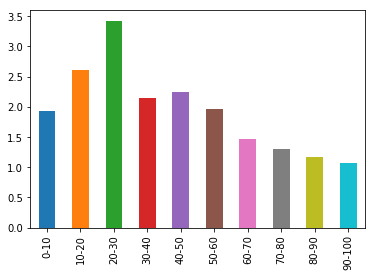

In [32]:
questions_per_asker_percentiles.plot(kind='bar')

**Answer:** Questions per asker is highest for the top 20-30% of askers by reputation.

* Why is it less for the less reputed? Maybe because they are less engaged.
* Why is it less for the more reputed? Maybe they are the experts, who answer more questions than they ask.

In [33]:
print len(askers), 'askers'
print len(questions), 'questions'

490 askers
952 questions


_Caveat:_ It's a pretty small sample. Don't believe it too much...

### Which questions are viewed the most?

Answer 1: Rank questions by ViewCount, and select the top few ranks using a mask.

In [34]:
# Rank the questions by ViewCount
count_ranks = questions['ViewCount'].rank(ascending=False)
# Make a mask of the top 10 ranks
mask = (count_ranks <= 10)
# Display the questions
questions[mask][['Title', 'ViewCount']]

,Title,ViewCount
339,Sort a pandas DataMatrix in ascending order,2484
347,append two data frame with pandas,2913
348,What is the most efficient way to loop through...,4228
354,Tutorial on PANDAS and PYTABLES,6454
367,How to get the correlation between two timeser...,2035
400,Add indexed column to DataFrame with pandas,2624
460,iterating row by row through a pandas dataframe,2052
463,add one row in a pandas.DataFrame,3238
516,Renaming columns in pandas,2422
723,How to fix Python Numpy/Pandas installation?,2066


Works, but not pleasing. What we want is to _sort_ by ViewCount.

In [35]:
questions.sort_values(by='ViewCount', ascending=False)[:10][['Title', 'ViewCount']]

,Title,ViewCount
354,Tutorial on PANDAS and PYTABLES,6454
348,What is the most efficient way to loop through...,4228
463,add one row in a pandas.DataFrame,3238
347,append two data frame with pandas,2913
400,Add indexed column to DataFrame with pandas,2624
339,Sort a pandas DataMatrix in ascending order,2484
516,Renaming columns in pandas,2422
723,How to fix Python Numpy/Pandas installation?,2066
460,iterating row by row through a pandas dataframe,2052
367,How to get the correlation between two timeser...,2035


## Other reshaping methods

<br />
Apart from pivot_table(), there are two main ways to reshape the data:

* **stack**, which "rotates" or pivots from columns to index, and
* **unstack**, which does the opposite.

It's easier with examples.

In [36]:
pivoted

Borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
Complaint Type,,,,,
Collection Truck Noise,NaN,6.0,5.0,4.0,1.0
Noise,115.0,536.0,1061.0,400.0,72.0
Noise - Commercial,163.0,698.0,1223.0,406.0,42.0
Noise - Helicopter,NaN,21.0,63.0,9.0,NaN
Noise - House of Worship,1.0,24.0,3.0,7.0,NaN
Noise - Park,2.0,NaN,17.0,11.0,NaN
Noise - Street/Sidewalk,109.0,208.0,609.0,100.0,19.0
Noise - Vehicle,53.0,183.0,228.0,75.0,18.0


### Stack

In [37]:
stacked = pivoted.stack()
stacked[:10]

Complaint Type          Borough      
Collection Truck Noise  BROOKLYN            6.0
                        MANHATTAN           5.0
                        QUEENS              4.0
                        STATEN ISLAND       1.0
Noise                   BRONX             115.0
                        BROOKLYN          536.0
                        MANHATTAN        1061.0
                        QUEENS            400.0
                        STATEN ISLAND      72.0
Noise - Commercial      BRONX             163.0
dtype: float64

We originally had:

* index = noise complaint type
* columns = borough

After stacking, the 'Borough' column becomes an extra level of the index; we get a _hierarchical_ index.

* first level of index = noise complaint type
* second level of index = borough

Notice that the NaN values are smoothly hidden in the stacked view.

### Unstack

Unstacking is the opposite of stacking; we move something from index to column.
In a hierarchical index, we can choose what to send from index to column.

In [38]:
stacked.unstack('Borough')[:3]  # we get back the pivoted DataFrame

Borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
Complaint Type,,,,,
Collection Truck Noise,NaN,6.0,5.0,4.0,1.0
Noise,115.0,536.0,1061.0,400.0,72.0
Noise - Commercial,163.0,698.0,1223.0,406.0,42.0


In [39]:
stacked.unstack('Complaint Type')[:3]  # we can also get it the other way

Complaint Type,Collection Truck Noise,Noise,Noise - Commercial,Noise - Helicopter,Noise - House of Worship,Noise - Park,Noise - Street/Sidewalk,Noise - Vehicle
Borough,,,,,,,,
BRONX,NaN,115.0,163.0,NaN,1.0,2.0,109.0,53.0
BROOKLYN,6.0,536.0,698.0,21.0,24.0,NaN,208.0,183.0
MANHATTAN,5.0,1061.0,1223.0,63.0,3.0,17.0,609.0,228.0


### Which type of noise complaint is most prevalent in each Borough?

In [40]:
pivoted[:5]

Borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
Complaint Type,,,,,
Collection Truck Noise,NaN,6.0,5.0,4.0,1.0
Noise,115.0,536.0,1061.0,400.0,72.0
Noise - Commercial,163.0,698.0,1223.0,406.0,42.0
Noise - Helicopter,NaN,21.0,63.0,9.0,NaN
Noise - House of Worship,1.0,24.0,3.0,7.0,NaN


If we only wanted the most prevalent complaint for one Borough (say, Bronx), what would we do?

In [41]:
# Getting the max value or index for a Series is easy.
print 'Most prevalent complaint for BRONX is', pivoted['BRONX'].idxmax()
print 'which occurred', pivoted['BRONX'].max(), 'times.'

Most prevalent complaint for BRONX is Noise - Commercial
which occurred 163.0 times.


The same _idxmax()_ function works for DataFrames as well

In [42]:
# For a DataFrame, the same thing works.
pivoted.idxmax()

Borough
BRONX            Noise - Commercial
BROOKLYN         Noise - Commercial
MANHATTAN        Noise - Commercial
QUEENS           Noise - Commercial
STATEN ISLAND                 Noise
dtype: object

In [43]:
# Similarly, getting the max value is easy.
pivoted.max()

Borough
BRONX             163.0
BROOKLYN          698.0
MANHATTAN        1223.0
QUEENS            406.0
STATEN ISLAND      72.0
dtype: float64

In [44]:
# How do we get both together?
most_common = DataFrame({'Most common complaint':pivoted.idxmax(), 'Num complaints':pivoted.max()})
most_common

,Most common complaint,Num complaints
Borough,,
BRONX,Noise - Commercial,163.0
BROOKLYN,Noise - Commercial,698.0
MANHATTAN,Noise - Commercial,1223.0
QUEENS,Noise - Commercial,406.0
STATEN ISLAND,Noise,72.0


### Summary

* **merge** combines multiple DataFrames into one
    * Useful when you want to ask questions whose answers lie in different DataFrames
* **rank**, which ranks the values in a Series
* **qcut**, which splits the values of a Series into percentiles
* **pivot_table**, which gives a break-up according to _values_ of columns in a DataFrame